# Clustering Experiments on CIFAR-10

In [1]:
# Try to keep all imports in this cell

import torch
import torchvision.datasets
import numpy as np
import pandas as pd
import os
import sklearn.pipeline
import sklearn.linear_model
import sklearn.cluster
import sklearn.decomposition
import matplotlib.pyplot as plt
import scipy
import time
import IPython
import random
from typing import Tuple, Optional

import concurrent.futures
import threading
import textwrap

try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError:
    raise Exception("text_extensions_for_pandas package not found on the Jupyter "
                    "kernel's path. Please either run:\n"
                    "   ln -s ../../text_extensions_for_pandas .\n"
                    "from the directory containing this notebook, or use a Python "
                    "environment on which you have used `pip` to install the package.")

# Keep the inputs and outputs of this script in their own subdirectories.
OUTPUT_DIR = "outputs/cifar10"
DATA_DIR = "data/cifar10"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Load the data set

In [2]:
# Grab the data set
cifar10_train = torchvision.datasets.CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = torchvision.datasets.CIFAR10(DATA_DIR, train=False, download=True)
cifar10_test

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/cifar10
    Split: Test

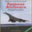

In [3]:
# PyTorch Dataset objects store images with PIL.
image, label = cifar10_test[3]
image

In [4]:
label, cifar10_train.classes[label]

(0, 'airplane')

In [5]:
# We'll need this number later on.
num_classes = len(cifar10_train.classes)
num_classes

10

## Load and run pretrained model

In [6]:
# Grab a pretrained model from https://github.com/chenyaofo/pytorch-cifar-models
model_repo_name = "chenyaofo/pytorch-cifar-models"
print(f"Available models:\n{torch.hub.list(model_repo_name)}")

# This model gets 94.22% top-1 and 99.80% top-5 accuracy on CIFAR-10.
model_name_core = "mobilenetv2_x1_4"

model_name = f"cifar10_{model_name_core}"

print(f"Using model: {model_name}")

model = torch.hub.load(model_repo_name, model_name, pretrained=True)
_ = model.eval()  # VERY IMPORTANT. Turns off dropout.

Using cache found in /Users/freiss/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /Users/freiss/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Available models:
['cifar100_mobilenetv2_x0_5', 'cifar100_mobilenetv2_x0_75', 'cifar100_mobilenetv2_x1_0', 'cifar100_mobilenetv2_x1_4', 'cifar100_repvgg_a0', 'cifar100_repvgg_a1', 'cifar100_repvgg_a2', 'cifar100_resnet20', 'cifar100_resnet32', 'cifar100_resnet44', 'cifar100_resnet56', 'cifar100_shufflenetv2_x0_5', 'cifar100_shufflenetv2_x1_0', 'cifar100_shufflenetv2_x1_5', 'cifar100_shufflenetv2_x2_0', 'cifar100_vgg11_bn', 'cifar100_vgg13_bn', 'cifar100_vgg16_bn', 'cifar100_vgg19_bn', 'cifar100_vit_b16', 'cifar100_vit_b32', 'cifar100_vit_h14', 'cifar100_vit_l16', 'cifar100_vit_l32', 'cifar10_mobilenetv2_x0_5', 'cifar10_mobilenetv2_x0_75', 'cifar10_mobilenetv2_x1_0', 'cifar10_mobilenetv2_x1_4', 'cifar10_repvgg_a0', 'cifar10_repvgg_a1', 'cifar10_repvgg_a2', 'cifar10_resnet20', 'cifar10_resnet32', 'cifar10_resnet44', 'cifar10_resnet56', 'cifar10_shufflenetv2_x0_5', 'cifar10_shufflenetv2_x1_0', 'cifar10_shufflenetv2_x1_5', 'cifar10_shufflenetv2_x2_0', 'cifar10_vgg11_bn', 'cifar10_vgg13_bn'

In [7]:
# Metadata required for inference, from
# https://github.com/chenyaofo/image-classification-codebase/blob/master/conf/cifar100.conf
image_size = 32
rgb_means = [0.4914, 0.4822, 0.4465]
rgb_stdevs = [0.2023, 0.1994, 0.2010]


# See https://github.com/chenyaofo/image-classification-codebase/blob/master/codebase/data/cifar.py
def preprocess_image(img) -> torch.Tensor:
    img_tensor = torchvision.transforms.ToTensor()(img)
    img_tensor = torchvision.transforms.Normalize(mean=rgb_means, std=rgb_stdevs)(img_tensor)
    img_tensor = img_tensor.unsqueeze(0)  # Convert to singleton batch
    return img_tensor

In [8]:
# Run an image through the model to verify it's loaded correctly
image_tensor = preprocess_image(image)
with torch.inference_mode():
    logits = model(image_tensor)[0]
    probs = torch.nn.functional.softmax(logits, dim=0)
print(f"Class Probabilities:\n{probs}")
print(f"Probability of corpus label: {probs[label]} at {label} "
      f"({cifar10_train.classes[label]})")
print(f"            Max probability: {torch.max(probs)} at {torch.argmax(probs)} "
      f"({cifar10_train.classes[torch.argmax(probs)]})")

Class Probabilities:
tensor([9.8583e-01, 3.6491e-04, 4.3578e-03, 7.5098e-03, 2.0080e-04, 6.6633e-05,
        1.0474e-04, 1.4466e-04, 5.0512e-04, 9.1883e-04])
Probability of corpus label: 0.9858266711235046 at 0 (airplane)
            Max probability: 0.9858266711235046 at 0 (airplane)


In [9]:
# Add a forward hook to retreive activations of the model from the
# layer before the classifier
activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model.features.register_forward_hook(get_activation("features"))

In [10]:
def image_to_features(img) -> np.ndarray:
    """
    Run an image through the model and retrieve the resulting classifier
    input features.

    :param img: PIL image object
    :returns: Tuple with:
     * Features for the image as a 1D NumPy array
     * Final outputs of the model (class probabilities) as a 1D NumPy array
    """
    with torch.inference_mode():
        # Construct a singleton batch and run it through the model.
        # This is not the most efficient way to do this, but the model's pretty
        # fast and we only have to do this operation once.
        img_tensor = preprocess_image(img)

        logits = model.forward(img_tensor)
        logits = torch.flatten(logits)

        # Convert logits to probabilities by running them through softmax
        probs = torch.nn.functional.softmax(logits, dim=0)

        # Alternate approach: Treat logits as the actual results of running 
        # probabilities through the logistic function.
        # probs = torch.special.expit(logits)
        # probs /= probs.sum()

        # Retrieve the features, which are 4x4-dimensional, and average pool them
        # down as the underlying model does.
        # `activation` is the dictionary that our callback uses.
        features = activation["features"]
        features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
        features = torch.flatten(features)
        return (features.detach().numpy(), probs.detach().numpy())


image_to_features(image)

(array([5.1562238e-02, 2.7803588e-05, 6.3632801e-03, ..., 2.8017934e-02,
        3.3155100e-03, 1.3174633e-02], dtype=float32),
 array([9.8582667e-01, 3.6490703e-04, 4.3578320e-03, 7.5097792e-03,
        2.0080140e-04, 6.6633154e-05, 1.0474072e-04, 1.4466424e-04,
        5.0512073e-04, 9.1883005e-04], dtype=float32))

In [11]:
def add_top_k_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    probs_array = df["probs"].array.to_numpy()
    num_examples = len(df.index)

    df["label_prob"] = probs_array[range(num_examples), df["label"].to_numpy()]
    df["top1"] = np.argmax(probs_array, axis=1)
    df["top1_prob"] = np.max(probs_array, axis=1)
    df["top5"] = tp.TensorArray(np.flip(np.argsort(probs_array)[:,-5:], axis=1))
    top5_mask = (
        np.any(
            np.equal(df["top5"].values, df["label"].values.reshape((-1,1))),
            axis=1)
    )
    df["top5_match"] = pd.Series(top5_mask, dtype=bool)
    return df


def maybe_generate_features(data_set: torch.utils.data.Dataset, cache_path: str):
    """
    If a result is available in the indicated cache file, load it into 
    a DataFrame. Otherwise, run all the images in a data set through the
    model's lower layers to generate feature vectors for the classifier 
    and write the resulting DataFrame of features and labels to the 
    cache location.

    :param data_set: Input set of images. Image should be element 0 of each
    tuple in the data set.
    :param cache_path: Path at which the resulting features DataFrame should
     be cached.
    """
    if not os.path.exists(cache_path):
        features_list = []
        labels_list = []
        probs_list = []
        for image, label in data_set:
            features, probs = image_to_features(image)
            features_list.append(features)
            labels_list.append(label)
            probs_list.append(probs)

        df = pd.DataFrame({
            "id": range(len(features_list)),
            "features": pd.Series(features_list, dtype=tp.TensorDtype()),
            "probs": pd.Series(probs_list, dtype=tp.TensorDtype()),
            "label": labels_list
        })
        df = add_top_k_cols(df)
        df.to_parquet(cache_path)
    return pd.read_parquet(cache_path)

In [12]:
%%time
# This takes about 2 minutes if the results aren't cached.
test = maybe_generate_features(cifar10_test, f"{OUTPUT_DIR}/cifar10_test.parquet")
test

CPU times: user 1.44 s, sys: 156 ms, total: 1.6 s
Wall time: 379 ms


,id,features,probs,label,label_prob,top1,top1_prob,top5,top5_match
0,0,"[ 0.35260808, 0.002510327, 0.001254929...","[ 2.894209e-08, 1.8942232e-07, 2.3131237e-0...",3,0.999998,3,0.999998,"[3, 5, 2, 8, 1]",True
1,1,"[ 0.02103011, 0.0048019644, 0.007733383...","[ 0.0002905918, 0.00021759795, 7.063145e-0...",8,0.998744,8,0.998744,"[8, 0, 1, 6, 3]",True
2,2,"[ 0.006070774, 2.754666e-05, 0.000503753...","[ 0.0014383381, 0.69928944, 0.0003394756...",8,0.297344,1,0.699289,"[1, 8, 0, 9, 2]",True
3,3,"[ 0.05156224, 2.7803588e-05, 0.0063632...","[ 0.9858267, 0.00036490703, 0.00435783...",0,0.985827,0,0.985827,"[0, 3, 2, 9, 8]",True
4,4,"[ 0.0, 0.02982047, 0.02614076...","[ 1.0584218e-06, 4.3281757e-06, 1.1705762e-0...",6,0.999957,6,0.999957,"[6, 4, 2, 3, 1]",True
...,...,...,...,...,...,...,...,...,...
9995,9995,"[ 0.08151524, 0.028122928, 0....","[ 0.00016568981, 4.195008e-05, 1.1431889e-0...",8,0.998522,8,0.998522,"[8, 5, 0, 3, 4]",True
9996,9996,"[ 0.2444532, 0.04218842, 0.003522765...","[ 2.7136082e-06, 4.621668e-06, 0.0001997103...",3,0.999213,3,0.999213,"[3, 4, 2, 5, 6]",True
9997,9997,"[ 0.15591726, 0.008372757, 0.000660977...","[ 1.553733e-05, 6.4611566e-05, 9.372406e-0...",5,0.999416,5,0.999416,"[5, 3, 2, 7, 1]",True
9998,9998,"[ 0.0043861214, 0.0011193305, 0.01134104...","[ 1.3735292e-05, 0.99993074, 7.4561776e-0...",1,0.999931,1,0.999931,"[1, 9, 0, 6, 8]",True


In [13]:
%%time
# This takes about 9 minutes if the results aren't cached.
train = maybe_generate_features(cifar10_train, f"{OUTPUT_DIR}/cifar10_train.parquet")
train

CPU times: user 886 ms, sys: 576 ms, total: 1.46 s
Wall time: 1.45 s


,id,features,probs,label,label_prob,top1,top1_prob,top5,top5_match
0,0,"[ 0.029165167, 0.013425681, 0.02106615...","[ 9.813224e-07, 2.0073671e-06, 2.1320864e-0...",6,0.999960,6,0.999960,"[6, 3, 5, 4, 8]",True
1,1,"[ 0.006221831, 1.14740105e-05, 0.01141228...","[ 1.3230983e-05, 2.10157e-05, 7.930732e-0...",9,0.999915,9,0.999915,"[9, 1, 8, 0, 2]",True
2,2,"[ 0.0, 0.0017763652, 0.02518254...","[ 2.8254426e-06, 2.7717265e-06, 4.7054687e-0...",9,0.999979,9,0.999979,"[9, 8, 2, 0, 1]",True
3,3,"[ 0.032992706, 0.23436683, 0.02305665...","[ 5.64204e-06, 3.447384e-06, 1.5888074e-0...",4,0.999827,4,0.999827,"[4, 7, 6, 3, 5]",True
4,4,"[ 0.023167439, 0.0018427392, 0.01341631...","[ 2.0382395e-05, 0.9998087, 1.1192387e-0...",1,0.999809,1,0.999809,"[1, 9, 8, 0, 5]",True
...,...,...,...,...,...,...,...,...,...
49995,49995,"[ 0.0, 0.0061797285, 0.002518399...","[ 0.0013843466, 5.5074956e-06, 0.998499...",2,0.998499,2,0.998499,"[2, 0, 4, 8, 6]",True
49996,49996,"[ 0.044538885, 0.00025054615, 0.003020350...","[ 1.8171737e-05, 0.000117755946, 5.6807778e-0...",6,0.997606,6,0.997606,"[6, 3, 1, 2, 4]",True
49997,49997,"[ 0.0, 0.0036740638, 0.00843777...","[ 6.8537454e-05, 0.00013954812, 1.854565e-0...",9,0.999516,9,0.999516,"[9, 8, 1, 0, 5]",True
49998,49998,"[ 0.018653711, 0.018397646, 0.03778621...","[ 2.1393242e-05, 0.9996331, 1.6347936e-0...",1,0.999633,1,0.999633,"[1, 8, 9, 7, 5]",True


## Calibrate the model

The steps that follow will work best if the model produces robustly calibrated class confidence values. Let's start with some code to generate a graph of calibration quality.

In [14]:
def make_calibration_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate raw data for determining how well-calibrated a model's
    class probabilities are.

    :param df: DataFrame of model results for a holdout or validation set.
               Each row represents one data item and must contain the 
               following columns:
               * `probs`: The model's returned class probabilities
               * `label`: The corpus label for the correct class

    :returns: A DataFrame with with one row for each combination of
     element and class, with the following columns:
     * `prediction`: Class label
     * `prob`: Probability that the model return for said class
     * `label`: Corpus label
     * `is_correct`: 0/1 indicator (integer dtype) that is 1 if 
       the label is correct.
     * `prob_bin`: Binned value of `prob`, with the bin size chosen
       to match the size of the input DataFrame.
    """
    target_bin_size = 100
    num_bins = len(df.index) * num_classes // target_bin_size

    # Shred the probability distributions and generate triples of
    # <predicted label, probability of label, actual label>
    triples_list = []
    for probs, label in zip(df["probs"], df["label"]):
        for predicted_label in range(num_classes):
            prob = probs.to_numpy()[predicted_label]
            triples_list.append({
                "prediction": predicted_label,
                "prob": prob,
                "label": label
            })

    calib = pd.DataFrame.from_records(triples_list)

    # Tack on a 0/1 indicator variable that is 1 if the predicted and actual
    # labels are the same
    calib["is_correct"] = (calib["prediction"] == calib["label"]).astype(int)

    # Divide the range from 0 to 1 into bins
    calib["prob_bin"] = pd.qcut(calib["prob"], num_bins)
    return calib


# Plot how well the example model is calibrated
def calibration_plot(df):
    (make_calibration_data(df).groupby("prob_bin").agg({"prob": "mean",
                                                        "is_correct": "mean"})
     .rename(columns={"is_correct": "empirical_prob", "prob": "model_prob"})
     .plot.scatter("model_prob", "empirical_prob"))


The above code lets us plot the calibration quality of the base model by showing the relationship between the model's output probability and the empirical probability (what fraction of the times that the model said an item was of label $l$ with (binned) probability $p$ was the label actually $l$)

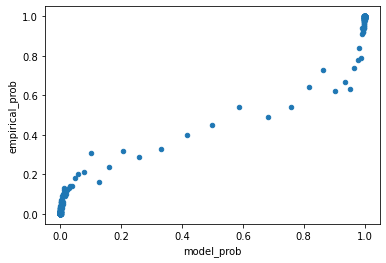

In [15]:
calibration_plot(test)

These model output probabilities are not terribly well-calibrated. There are several ways to fix that. Here we calibrate the model by retraining the top layer with additional L2 regularization.

In [16]:
%%time
# Train a multinomial logistic regression model on the training set.
_MULTI_CLASS = "multinomial"
_SOLVER, _SOLVER_LOG_LEVEL = ("lbfgs", 0)

# (from docs) "Inverse of regularization strength; must be a positive float. 
# Like in support vector machines, smaller values specify stronger regularization."
# Default values
#_REGULARIZATION_TYPE, _REGULARIZATION_COEFF = ("l2", 1e0)

# This value produces a model with a nice straight calibration curve
_REGULARIZATION_TYPE, _REGULARIZATION_COEFF = ("l2", 2e-3)

def train_model(df: pd.DataFrame,
                     regularization_type=_REGULARIZATION_TYPE,
                     regularization_coeff=_REGULARIZATION_COEFF) -> sklearn.base.BaseEstimator:  
    base_pipeline = sklearn.pipeline.Pipeline([
        # Standard scaler. This only makes a difference for certain classes
        # of embeddings.
        #("scaler", sklearn.preprocessing.StandardScaler()),
        ("mlogreg", sklearn.linear_model.LogisticRegression(
            multi_class=_MULTI_CLASS,
            max_iter=1000,
            verbose=_SOLVER_LOG_LEVEL,
            penalty=regularization_type,
            C=regularization_coeff,
            solver=_SOLVER))
    ])
    return base_pipeline.fit(df["features"].values, df["label"])


calib_model = train_model(train)

CPU times: user 41.6 s, sys: 7.02 s, total: 48.6 s
Wall time: 3.79 s


Now we can run our model over the saved activations from the test set and redo the calibration graph.

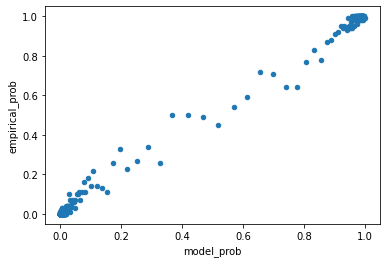

In [17]:
def rerun_top_layer(data: pd.DataFrame, model: sklearn.base.BaseEstimator) -> pd.DataFrame:
    df = data[["id", "label"]].copy()
    df["probs"] = tp.TensorArray(model.predict_proba(data["features"].values))
    df = add_top_k_cols(df[["id", "probs", "label"]])
    return df


c_test = rerun_top_layer(test, calib_model)

calibration_plot(c_test)

## Method 1: K-means

As a baseline method, we'll cluster the model outputs into groups based purely on similarity of the vectors of returned model probabilities.

### 10 Clusters

We'll start with the number of clusters equal to the number of classes and see what happens.

In [18]:
def make_clusters(model_probs: np.ndarray,
                  num_clusters: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    KMeans clustering, sorting the clusters according to which class has
    the highest weight.

    :param model_probs: 2D ndarray of class probabilities output by the 
     model. First dimension is element number, second dimension is class.
    :param num_clusters: Number of clusters to divide the probabilities into

    :returns: Tuple of:
              * Cluster IDs corresponding to the rows of ``model_probs``
              * Cluster centroids as a 2D ndarray
    """
    kmeans = sklearn.cluster.KMeans(
        n_clusters=num_clusters, 
        # n_init=100, max_iter=10000, tol=1e-6
    ).fit(model_probs)
    clusters = kmeans.cluster_centers_
    cluster_ids = kmeans.predict(model_probs)

    # First dimension of clusters is cluster number.
    # Construct a sort key that is the rank of each element,
    # appended with cluster number.
    sort_keys = [
        tuple(np.argsort(clusters[i])[::-1]) + (i,) for i in range(clusters.shape[0])
    ]
    sort_order = [t[-1] for t in sorted(sort_keys)]
    sorted_clusters = clusters[sort_order]

    inverted_sort_order = np.zeros_like(sort_order)
    for i in range(len(sort_order)):
        inverted_sort_order[sort_order[i]] = i
    sorted_cluster_ids = inverted_sort_order[cluster_ids]

    return sorted_cluster_ids, sorted_clusters


def add_clusters_col(df: pd.DataFrame, num_clusters: int):
    """
    :param df: DataFrame containing one vector of class probabilities per row
     in a column called "probs"
    :param num_clusters: Number of clusters to divide the probabilities into

    :returns: A copy of `df` with a new (or replaced) column called "c_{num_clusters}"
     containing cluster IDs for the requested clustering
    """
    df = df.copy()
    cluster_ids, _ = make_clusters(df["probs"].to_numpy(), num_clusters)
    df[f"c_{num_clusters}"] = cluster_ids
    return df


clusters = add_clusters_col(c_test, 10)
clusters

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match,c_10
0,0,"[ 9.324214151936674e-05, 0.000237297089221795...",3,0.998793,3,0.998793,"[3, 8, 1, 2, 4]",True,3
1,1,"[ 0.006146121307375569, 0.00580862711389710...",8,0.961217,8,0.961217,"[8, 0, 1, 6, 3]",True,8
2,2,"[ 0.014238712139555383, 0.577040633698757...",8,0.366036,1,0.577041,"[1, 8, 0, 9, 2]",True,1
3,3,"[ 0.8648255592974857, 0.00994625824493783...",0,0.864826,0,0.864826,"[0, 3, 2, 9, 8]",True,0
4,4,"[ 0.0006253539875008178, 0.001303845829813...",6,0.990238,6,0.990238,"[6, 4, 2, 1, 3]",True,6
...,...,...,...,...,...,...,...,...,...
9995,9995,"[ 0.00441212176824998, 0.00214001242323343...",8,0.966744,8,0.966744,"[8, 5, 0, 4, 3]",True,8
9996,9996,"[ 0.001236129401929248, 0.00158755666638597...",3,0.971884,3,0.971884,"[3, 4, 2, 5, 6]",True,3
9997,9997,"[ 0.0031452989990810214, 0.00600395515443142...",5,0.957697,5,0.957697,"[5, 1, 2, 7, 3]",True,5
9998,9998,"[ 0.001472712483878206, 0.991317488106108...",1,0.991317,1,0.991317,"[1, 0, 6, 9, 2]",True,1


10 clusters should naturally lead to each cluster holding examples that the model placed into a single class. Let's eyeball some results.

In [19]:
clusters[clusters["c_10"] == 5].head(7)

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match,c_10
12,12,"[ 0.003423826629608556, 0.00393293374360110...",5,0.927703,5,0.927703,"[5, 3, 7, 4, 6]",True,5
16,16,"[ 0.002930540281976007, 0.00286885334888248...",5,0.951841,5,0.951841,"[5, 7, 6, 2, 4]",True,5
24,24,"[ 0.0005795539927787086, 0.000979128718453004...",5,0.983849,5,0.983849,"[5, 3, 4, 1, 9]",True,5
31,31,"[ 0.001345639491229316, 0.001626018364684382...",5,0.983316,5,0.983316,"[5, 6, 2, 4, 7]",True,5
33,33,"[ 0.001691865895800718, 0.001481394840513017...",5,0.969552,5,0.969552,"[5, 2, 4, 8, 7]",True,5
39,39,"[ 0.002429169290115843, 0.002685917468413320...",5,0.971479,5,0.971479,"[5, 7, 3, 2, 9]",True,5
42,42,"[ 0.0013007750600714356, 0.000770994132128651...",5,0.992657,5,0.992657,"[5, 0, 3, 7, 4]",True,5


In [20]:
clusters.groupby(["c_10", "top1"]).agg({"id": "count"}).rename(columns={"id": "count"})

count
c_10 top1       
0    0      1004
     8         1
     9         1
1    1      1009
2    2       985
     7         1
3    2         1
     3       969
     5         1
4    4      1038
     7         1
5    2         1
     5       997
6    6      1018
7    7       968
8    8       999
9    9      1006

Image 5576:


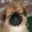

Corpus label: 5 ==> dog
Top 5 results: [5 4 2 6 9] ==> ['dog', 'deer', 'bird', 'frog', 'truck']
Image 3949:


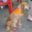

Corpus label: 5 ==> dog
Top 5 results: [5 3 6 7 2] ==> ['dog', 'cat', 'frog', 'horse', 'bird']
Image 6092:


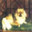

Corpus label: 5 ==> dog
Top 5 results: [5 6 3 7 9] ==> ['dog', 'frog', 'cat', 'horse', 'truck']
Image 9540:


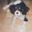

Corpus label: 5 ==> dog
Top 5 results: [5 2 7 4 6] ==> ['dog', 'bird', 'horse', 'deer', 'frog']
Image 6389:


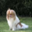

Corpus label: 5 ==> dog
Top 5 results: [5 3 7 8 4] ==> ['dog', 'cat', 'horse', 'ship', 'deer']


In [21]:
def result_report(df: pd.DataFrame, fold_data, index_id: int = None):
    """
    Generate a report on a particular model result.

    :param df: DataFrame of model results as returned by `make_results()`.
     Must have the following columns:
     * `id`: Index into `fold_data` of the input data element
     * `top5`: Top 5 results from the model
     * `label`: Label from the source data, for validation
    :param fold_data:  Data structure containing source data for the fold.
    :param index_id: Value of the index of `df` for the row containing
     the result in question
    """
    row = df.loc[index_id]
    element_id = row["id"]
    image, label = fold_data[element_id]

    # Sanity check: Make sure the labels match up
    if label != row["label"]:
        raise ValueError(f"Labels don't match ({label} != {row['label']}")

    top5 = row["top5"].to_numpy()
    print(f"Image {element_id}:")
    IPython.display.display(IPython.display.Image(data=image._repr_png_()))
    print(f"Corpus label: {label} ==> {fold_data.classes[label]}")
    print(f"Top 5 results: {top5} ==> {[fold_data.classes[l] for l in top5]}")


def results_report(df: pd.DataFrame):
    for ix in df.index:
        result_report(df, cifar10_test, ix)

results_report(clusters[clusters["c_10"] == 5].sample(5))

### More clusters

If we group the class probabilities into more than 10 clusters, some of the classes should end up getting split into sub-classes.

In [22]:
for num_clusters in (20, 50, 100):
    clusters = add_clusters_col(clusters, num_clusters)
clusters

,id,probs,label,label_prob,top1,top1_prob,top5,top5_match,c_10,c_20,c_50,c_100
0,0,"[ 9.324214151936674e-05, 0.000237297089221795...",3,0.998793,3,0.998793,"[3, 8, 1, 2, 4]",True,3,6,18,36
1,1,"[ 0.006146121307375569, 0.00580862711389710...",8,0.961217,8,0.961217,"[8, 0, 1, 6, 3]",True,8,17,44,86
2,2,"[ 0.014238712139555383, 0.577040633698757...",8,0.366036,1,0.577041,"[1, 8, 0, 9, 2]",True,1,3,6,14
3,3,"[ 0.8648255592974857, 0.00994625824493783...",0,0.864826,0,0.864826,"[0, 3, 2, 9, 8]",True,0,1,2,6
4,4,"[ 0.0006253539875008178, 0.001303845829813...",6,0.990238,6,0.990238,"[6, 4, 2, 1, 3]",True,6,13,35,72
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,"[ 0.00441212176824998, 0.00214001242323343...",8,0.966744,8,0.966744,"[8, 5, 0, 4, 3]",True,8,17,44,86
9996,9996,"[ 0.001236129401929248, 0.00158755666638597...",3,0.971884,3,0.971884,"[3, 4, 2, 5, 6]",True,3,6,18,36
9997,9997,"[ 0.0031452989990810214, 0.00600395515443142...",5,0.957697,5,0.957697,"[5, 1, 2, 7, 3]",True,5,10,32,64
9998,9998,"[ 0.001472712483878206, 0.991317488106108...",1,0.991317,1,0.991317,"[1, 0, 6, 9, 2]",True,1,2,7,15


In [23]:
clusters.groupby(["c_20", "top1"]).agg({"id": "count"}).rename(columns={"id": "count"})

count
c_20 top1       
0    0        85
     9         1
1    0       915
2    1       961
3    1        46
     9         1
4    2       883
5    2       102
6    3       818
7    3       142
8    2         2
     4        96
9    4       940
10   5       904
11   0         1
     3         7
     4         1
     5        93
12   3         1
     6        72
13   6       946
14   7       912
15   3         1
     4         1
     5         1
     7        58
16   0         3
     1         2
     8        49
17   8       951
18   9        70
19   9       935

Image 9983:


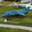

Corpus label: 0 ==> airplane
Top 5 results: [0 1 7 8 6] ==> ['airplane', 'automobile', 'horse', 'ship', 'frog']
Image 2136:


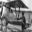

Corpus label: 0 ==> airplane
Top 5 results: [0 9 8 7 1] ==> ['airplane', 'truck', 'ship', 'horse', 'automobile']
Image 4038:


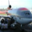

Corpus label: 0 ==> airplane
Top 5 results: [0 9 8 1 5] ==> ['airplane', 'truck', 'ship', 'automobile', 'dog']
Image 8898:


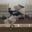

Corpus label: 7 ==> horse
Top 5 results: [0 7 2 8 4] ==> ['airplane', 'horse', 'bird', 'ship', 'deer']
Image 6284:


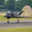

Corpus label: 0 ==> airplane
Top 5 results: [0 7 2 3 4] ==> ['airplane', 'horse', 'bird', 'cat', 'deer']


In [24]:
results_report(clusters[clusters["c_20"] == 0].sample(5))

Image 8857:


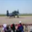

Corpus label: 0 ==> airplane
Top 5 results: [0 8 9 7 2] ==> ['airplane', 'ship', 'truck', 'horse', 'bird']
Image 8163:


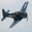

Corpus label: 0 ==> airplane
Top 5 results: [0 6 9 3 2] ==> ['airplane', 'frog', 'truck', 'cat', 'bird']
Image 180:


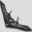

Corpus label: 0 ==> airplane
Top 5 results: [0 3 4 1 2] ==> ['airplane', 'cat', 'deer', 'automobile', 'bird']
Image 382:


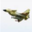

Corpus label: 0 ==> airplane
Top 5 results: [0 2 8 9 6] ==> ['airplane', 'bird', 'ship', 'truck', 'frog']
Image 21:


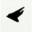

Corpus label: 0 ==> airplane
Top 5 results: [0 6 8 2 7] ==> ['airplane', 'frog', 'ship', 'bird', 'horse']


In [25]:
results_report(clusters[clusters["c_20"] == 1].sample(5))

In [26]:
clusters.groupby(["c_50", "top1"]).agg({"id": "count"}).rename(columns={"id": "count"}).head(20)

count
c_50 top1       
0    0        11
     2         3
1    0        39
2    0        89
3    0       839
4    0        13
     8         4
5    0        11
     9         4
6    0         1
     1        20
7    1       961
8    1        28
9    2       808
10   2        12
11   2        13
     3         3
12   2        89
13   2        43
14   2         9

Image 882:


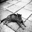

Corpus label: 3 ==> cat
Top 5 results: [0 2 3 7 1] ==> ['airplane', 'bird', 'cat', 'horse', 'automobile']
Image 3601:


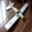

Corpus label: 0 ==> airplane
Top 5 results: [2 0 3 4 5] ==> ['bird', 'airplane', 'cat', 'deer', 'dog']
Image 4286:


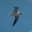

Corpus label: 2 ==> bird
Top 5 results: [0 2 3 9 4] ==> ['airplane', 'bird', 'cat', 'truck', 'deer']
Image 125:


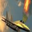

Corpus label: 0 ==> airplane
Top 5 results: [0 2 9 4 1] ==> ['airplane', 'bird', 'truck', 'deer', 'automobile']
Image 655:


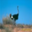

Corpus label: 2 ==> bird
Top 5 results: [0 2 4 7 8] ==> ['airplane', 'bird', 'deer', 'horse', 'ship']


In [27]:
results_report(clusters[clusters["c_50"] == 0].sample(5))

Image 5074:


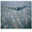

Corpus label: 0 ==> airplane
Top 5 results: [0 8 3 9 2] ==> ['airplane', 'ship', 'cat', 'truck', 'bird']
Image 7816:


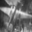

Corpus label: 0 ==> airplane
Top 5 results: [0 3 4 2 7] ==> ['airplane', 'cat', 'deer', 'bird', 'horse']
Image 2643:


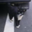

Corpus label: 3 ==> cat
Top 5 results: [0 3 4 5 7] ==> ['airplane', 'cat', 'deer', 'dog', 'horse']
Image 7861:


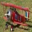

Corpus label: 0 ==> airplane
Top 5 results: [0 9 7 2 6] ==> ['airplane', 'truck', 'horse', 'bird', 'frog']
Image 7843:


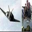

Corpus label: 0 ==> airplane
Top 5 results: [0 3 7 9 4] ==> ['airplane', 'cat', 'horse', 'truck', 'deer']


In [28]:
results_report(clusters[clusters["c_50"] == 1].sample(5))

In [29]:
clusters.groupby(["c_100", "top1"]).agg({"id": "count"}).rename(columns={"id": "count"}).head(20)

count
c_100 top1       
0     0        19
1     0        10
      2         3
2     0         8
3     0         4
      6         1
4     0         3
5     0         7
6     0        60
7     0       712
8     0       150
9     0         7
      8         5
10    0        10
11    0        11
12    0         3
      9         4
13    1         9
14    1         6
      8         2

### Relationship between cluster ID and corpus label


In [30]:
clusters.groupby(["c_10", "label"]).agg({"id": "count"}).rename(columns={"id": "count"}).head(20)

count
c_10 label       
0    0        943
     2         14
     3          8
     4          1
     5          2
     6          6
     7          6
     8         16
     9         10
1    0          4
     1        976
     3          1
     5          1
     6          1
     8          5
     9         21
2    0         12
     1          1
     2        923
     3         16

In [31]:
clusters.groupby(["c_20", "label"]).agg({"id": "count"}).rename(columns={"id": "count"}).head(20)

count
c_20 label       
0    0         52
     2          8
     3          6
     5          1
     6          3
     7          4
     8          5
     9          7
1    0        887
     2          5
     3          2
     4          1
     5          1
     6          3
     7          2
     8         11
     9          3
2    0          3
     1        948
     8          2

In [32]:
clusters.groupby(["c_100", "label"]).agg({"id": "count"}).rename(columns={"id": "count"}).head(20)

count
c_100 label       
0     0         14
      2          1
      5          1
      6          1
      9          2
1     0          6
      2          5
      3          1
      9          1
2     0          2
      3          4
      6          1
      7          1
3     0          3
      6          2
4     2          2
      7          1
5     0          4
      3          1
      7          2

## Method 2: Matrix factorization

In this approach, we factor the model's output probabilities into a noise transition matrix and a matrix of true class weights.

This factorization is bit tricky because want the factors to be as large as or larger than the original matrices. So we need to regularize and constrain aggressively in order to have a problem formulation that is not underspecified.

### Baseline: Scikit learn NMF out of the box

For starters, we'll try a canned nonnegative matrix factorization algorithm from sklearn. This algorithm allows for both L1 and L2 regularization. See docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html).

In [33]:
num_subclasses = 20

# Best regularization coefficients I've been able to find by trial and error
left_reg_coeff = 1e-3
top_reg_coeff = 1e0

# Optionally sample to make things faster
num_examples = 10000
if num_examples > len(c_test.index):
    raise ValueError(f"Too many examples requested"
                     f"({num_examples} > {len(c_test.index)}")


model_probs = c_test.sample(num_examples)["probs"].to_numpy()

nmf = sklearn.decomposition.NMF(n_components=num_subclasses,
                                init="random",
                                alpha_H=top_reg_coeff,
                                alpha_W=left_reg_coeff,
                                l1_ratio=1e-5,
                                max_iter=100000
                               )
left_factor = nmf.fit_transform(model_probs)
top_factor = nmf.components_

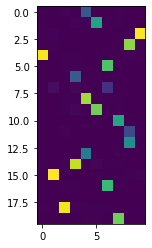

In [34]:
plt.imshow(top_factor)

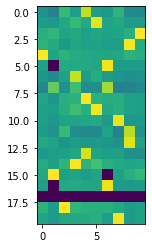

In [35]:
epsilon = 1e-7
plt.imshow(np.log(np.maximum(top_factor, epsilon)))

In [36]:
top_factor[0] / np.sum(top_factor[0])

array([0.00332567, 0.00125191, 0.03061325, 0.00671826, 0.91901054,
       0.00639591, 0.00450338, 0.02444346, 0.00209256, 0.00164505])

In [37]:
# How close are the "probabilities" from NMF to summing to 1?
np.sum(top_factor, axis=1)

array([0.04228952, 0.08770215, 0.14741831, 0.12264489, 0.14682944,
       0.1068121 , 0.04316855, 0.027288  , 0.12813919, 0.11769322,
       0.08891143, 0.03416083, 0.07420616, 0.06223421, 0.13777693,
       0.14720201, 0.09947897, 0.        , 0.14563985, 0.11534401])

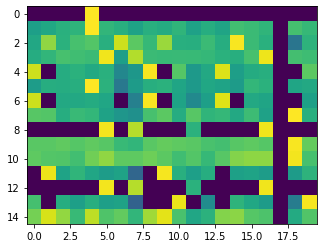

In [38]:
plt.imshow(np.log(np.maximum(left_factor[:15], epsilon)))

The NMF clustering tends to produce one cluster per class. Give the algorithm more than 10 clusters and it splits a given class roughly 50-50 between two more or less identical clusters.  Tweaking the regularization doesn't really help, because the library function always uses the same ratio of L1 to L2 regularization for both factors.

A secondary issue is that the probabilities in each row of the transition matrix don't sum to 1, and the total sum varies from one cluster to the next.

### Approach 2: ALS with regularization and constraints

This approach to factorization factorizes the model outputs matrix using Alternating Least Squares while applying different regularizations and constraints to the two factors. We want the top factor (the transition matrix) to be dense and to have each row sum to exactly 1. We want the left factor (model's probabilities of subclasses) to be sparse and to have each row sum to exactly 1.

#### Objective functions
We'll use `scipy.optimize.mimimize` to set up and solve the two minimization problems. First we define the objective functions.

In [39]:
def base_loss(left_factor: np.ndarray, top_factor: np.ndarray,
              model_probs: np.ndarray) -> float:
    """
    :param left_factor: Current value of the left factor as a 2D ndarray
    :param top_factor: Current value of the top factor as a 2D ndarray
    :param model_probs: 2D ndarray of returned probabilities from the model.
    
    :returns: Base component of the loss for the matrix factorization
     problem. This component measures the difference between the product
     and the target product.
    """
    product = np.matmul(left_factor, top_factor)
    
    # Original version: L2 norm, i.e. Frobenius norm
    return np.linalg.norm(product - model_probs)
    
    # Alternative: Plain difference.
    #return np.sum(np.abs(product - model_probs))

def top_factor_loss(x: np.ndarray,
                    left_factor: np.ndarray,
                    model_probs: np.ndarray,
                    top_reg_coeff: float) -> float:
    """
    :param x: The coefficients of the top factor, flattened into a 
     1D array per the ``scipy.optimize.minimize`` API.
    :param left_factor: Current value of the left factor as a 2D ndarray
    :param model_probs: 2D ndarray of returned probabilities from the model.
    :param top_reg_coeff: Regularization coefficient for the value of the
     top factor, which is L2 regularized.

    :returns: Total loss for the top factor
    """
    num_subclasses = left_factor.shape[1]
    top_factor = x.reshape((num_subclasses, num_classes))
    product = np.matmul(left_factor, top_factor)

    # We L2-regularlize the top factor to discourage the optimizer from
    # picking the identity matrix
    top_reg_penalty = top_reg_coeff * np.linalg.norm(top_factor)

    return base_loss(left_factor, top_factor, model_probs) + top_reg_penalty


def left_factor_loss(x: np.ndarray,
                     top_factor: np.ndarray,
                     model_probs: np.ndarray,
                     left_reg_coeff: float) -> float:
    """
    :param x: The coefficients of the top factor, flattened into a 
     1D array per the ``scipy.optimize.minimize`` API.
    :param top_factor: Current value of the top factor as a 2D ndarray
    :param model_probs: 2D ndarray of returned probabilities from the model.
    :param left_reg_coeff: L2 regularization coefficient for the value of the
     left factor.

    :returns: Total loss for the left factor
    """
    num_elements = model_probs.shape[0]
    num_subclasses = top_factor.shape[0]
    left_factor = x.reshape((num_elements, num_subclasses))
    product = np.matmul(left_factor, top_factor)

    # We used to L1-regularize the left factor to encourage sparsity.
    # But that's not needed if we are constraining the sum of each row!
    # Instead we add on L2 regularization.
    left_reg_penalty = left_reg_coeff * np.linalg.norm(top_factor)

    #return base_loss + left_reg_penalty
    return base_loss(left_factor, top_factor, model_probs) + left_reg_penalty

#### Constraints

Next we define constraints for the the two factors, such that things that are supposed to be probabilities will sum to 1.

In [40]:
# Scipy constraint format is lb <= A.dot(x) <= ub
# We need to generate a mask `A` with one row for each constraint.
EPSILON = 0.0


def top_constraint(num_subclasses: int) -> scipy.optimize.LinearConstraint:
    """
    Constrain each row of the top factor to sum to 1 +/- ``EPSILON``
    """
    masks = []
    for subclass_num in range(num_subclasses):
        mask = np.zeros((num_subclasses, num_classes))
        mask[subclass_num, :] = 1.
        masks.append(mask)
    masks_matrix = np.stack(masks).reshape((num_subclasses, -1))

    return scipy.optimize.LinearConstraint(
        # A: {array_like, sparse matrix}, shape (m, n): Matrix defining the
        # constraint.
        masks_matrix,
        # lb: array_like: Lower bounds
        np.full(masks_matrix.shape[0], 1. - EPSILON),
        # ub: array_like: Upper bounds
        np.full(masks_matrix.shape[0], 1. + EPSILON),
        keep_feasible=False)


def left_constraint(num_elements: int,
                    num_subclasses: int) -> scipy.optimize.LinearConstraint:
    """
    Constrain each row of the left factor to sum to 1 +/- ``EPSILON``

    :param num_elements: Number of elements in the test set
    :param num_subclasses: Number of hidden subclasses
    """
    masks = []
    for element_num in range(num_elements):
        mask = np.zeros((num_elements, num_subclasses))
        mask[element_num, :] = 1.
        masks.append(mask)
    masks_matrix = np.stack(masks).reshape((num_elements, -1))

    return scipy.optimize.LinearConstraint(
        # A: {array_like, sparse matrix}, shape (m, n): Matrix defining the
        # constraint.
        masks_matrix,
        # lb: array_like: Lower bounds
        np.full(masks_matrix.shape[0], 1. - EPSILON),
        # ub: array_like: Upper bounds
        np.full(masks_matrix.shape[0], 1. + EPSILON),
        keep_feasible=False)

#### Inner loop of ALS

Now we can set up the two optimization problems for the alternating phases of ALS.

In [66]:
def no_hessian(x: np.ndarray, *args):
    return np.zeros(shape=(x.shape[0], x.shape[0]))

def solve_for_top(model_probs: np.ndarray, left_factor: np.ndarray,
                  top_reg_coeff: float,
                  starting_values: np.ndarray) -> np.ndarray:
    """
    Find the new optimal top factor, given a fixed value for the left factor.

    :param model_probs: Matrix that we are factorizing
    :param left_factor: Current value of the left-hand factor
    :param top_reg_coeff: Regularization coefficient for the L2 
     regularization of the top factor.

    :returns: Tuple of:
              * New value for top factor
              * Detailed output of :func:`scipy.optimize.minimize`
    """
    num_subclasses = left_factor.shape[1]

    starting_values_flat = starting_values.flatten()

    # Massage the problem into the format the scipy.optimize expects
    fixed_args = (left_factor, model_probs, top_reg_coeff)
    bounds = [(0., 1.) for _ in range(len(starting_values_flat))]
    constraints = top_constraint(num_subclasses)

    result = scipy.optimize.minimize(top_factor_loss, 
                                     starting_values_flat,
                                     args=fixed_args, bounds=bounds,
                                     method="trust-constr",
                                     constraints=constraints,
                                     hess=no_hessian)
    new_top_factor = result.x.reshape(starting_values.shape)
    return new_top_factor, result


def solve_for_left(model_probs: np.ndarray, top_factor: np.ndarray,
                   left_reg_coeff: float,
                   starting_values: np.ndarray) -> np.ndarray:
    """
    Find the new optimal left factor, given a fixed value for the top factor.

    :param model_probs: Matrix that we are factorizing
    :param top_factor: Current value of the top (second) factor
    :param left_reg_coeff: Regularization coefficient for the L2 
     regularization of the left factor.

    :returns: Tuple of:
              * New value for left factor
              * Detailed output of :func:`scipy.optimize.minimize`
    """
    num_elements, num_subclasses = starting_values.shape
    starting_values_flat = starting_values.flatten()

    # Massage the problem into the format the scipy.optimize expects
    fixed_args = (top_factor, model_probs, left_reg_coeff)
    bounds = [(0., 1.) for _ in range(len(starting_values_flat))]
    constraints = left_constraint(num_elements, num_subclasses)

    result = scipy.optimize.minimize(left_factor_loss,
                                     starting_values_flat,
                                     args=fixed_args, bounds=bounds,
                                     method="trust-constr",
                                     constraints=constraints,
                                     hess=no_hessian)
    new_top_factor = result.x.reshape(starting_values.shape)
    return new_top_factor, result

In [67]:
def make_initial_values(
    model_results: pd.DataFrame,
    num_subclasses: int,
    sample_size: Optional[int] = None
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Create some starting values for the two factors by running K-means
    and optionally choosing a sample of the data set.
    :param model_results: DataFrame of model results, with one row 
     per input example. Must contain a column ``probs`` with model output
     class probabilities.
    :param num_subclasses: Number of hidden subclasses, i.e. shared dimension
     of the factors.
    :param sample_size: Optional size of the sample to take from the data
     set, or ``None`` to use the entire data set.

    :returns: Tuple of initial values for left factor and top factor and
     (sampled) product
    """
    if sample_size is not None and sample_size > len(model_results.index):
        raise ValueError(f"Too many examples requested"
                         f"({num_examples} > {len(model_results.index)}")
    elif sample_size is None:
        sample_size = len(model_results.index)

    # Extract the requested sample of the input
    product = model_results.sample(sample_size)["probs"].to_numpy()

    # Use kmeans to generate some starting values.
    cluster_ids, clusters = make_clusters(product, num_subclasses)

    # Dummy-code the cluster IDs from KMeans
    left_factor = np.zeros((sample_size, num_subclasses), dtype=np.float32)
    left_factor[range(sample_size), cluster_ids] = 1.
    top_factor = clusters

    return left_factor, top_factor, product

In [68]:
# Set up the initial conditions and constants for the first round
# of tests.
num_subclasses = 20
sample_size = 100
left_reg_coeff = 0
top_reg_coeff = 1e-1

left_factor, top_factor, product = make_initial_values(
    c_test, num_subclasses, sample_size)

CPU times: user 7min 2s, sys: 1min 5s, total: 8min 8s
Wall time: 33.5 s


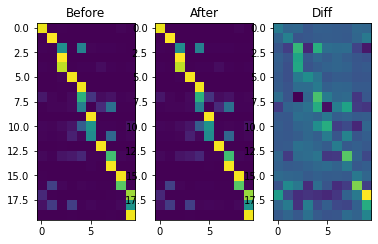

In [69]:
%%time
# Perform one iteration of solving for the top factor
next_top, _ = solve_for_top(product, left_factor, top_reg_coeff,
                            top_factor)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title("Before")
ax1.imshow(top_factor)
ax2.set_title("After")
ax2.imshow(next_top)
ax3.set_title("Diff")
ax3.imshow(top_factor - next_top)

CPU times: user 26min 16s, sys: 4min 5s, total: 30min 21s
Wall time: 2min 6s


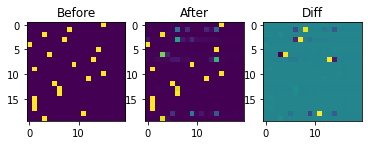

In [70]:
%%time
# Perform one iteration of solving for just the first few rows of the
# left factor
num_rows = 20

product_rows = product[:num_rows]
left_factor_rows = left_factor[:num_rows]

next_left, _ = solve_for_left(product_rows, top_factor, left_reg_coeff,
                              left_factor_rows)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title("Before")
ax1.imshow(left_factor_rows)
ax2.set_title("After")
ax2.imshow(next_left)
ax3.set_title("Diff")
ax3.imshow(left_factor_rows - next_left)

Solving for the entire left factor at once doesn't scale with this solver, but we can solve quickly for one row at a time. Here's a function that wraps that approach.

In [71]:
def solve_for_left_by_row(model_probs: np.ndarray, 
                          top_factor: np.ndarray,
                          left_reg_coeff: float,
                          starting_values: np.ndarray) -> np.ndarray:
    """
    Find the new optimal left factor, given a fixed value for the 
    top factor. Treats each row of the left factor as an independent
    optimization problem.

    :param model_probs: Matrix that we are factorizing
    :param top_factor: Current value of the top (second) factor
    :param left_reg_coeff: Regularization coefficient for the L2 
     regularization of the left factor.

    :returns: new value for left factor
    """
    num_elements = model_probs.shape[0]
    result = np.zeros_like(starting_values)
    for row_num in range(num_elements):
        # Pull out a pair of (1 x num_subclasses) matrices
        model_probs_row = model_probs[row_num:row_num + 1]
        starting_values_row = starting_values[row_num:row_num + 1]

        next_row_values, _ = solve_for_left(
            model_probs_row, top_factor, left_reg_coeff,
            starting_values_row)
        result[row_num] = next_row_values
    return result

CPU times: user 1min 7s, sys: 102 ms, total: 1min 7s
Wall time: 1min 7s


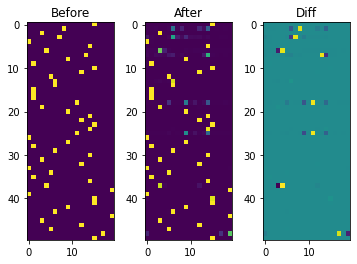

In [72]:
%%time

next_left = solve_for_left_by_row(
    product, top_factor, left_reg_coeff, left_factor)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

num_rows_to_display = 50
ax1.set_title("Before")
ax1.imshow(left_factor[:num_rows_to_display])
ax2.set_title("After")
ax2.imshow(next_left[:num_rows_to_display])
ax3.set_title("Diff")
ax3.imshow(left_factor[:num_rows_to_display] - next_left[:num_rows_to_display])

#### Outer loop of ALS

Now we can define the outer loop that alternates between solving for the top and left factors.

In [79]:
def als_factorize(model_results: pd.DataFrame,
                  num_subclasses: int,
                  sample_size: int,
                  num_iterations: int,
                  top_reg_coeff: float,
                  left_reg_coeff: float):
    """
    :param model_results: DataFrame of model results, with one row 
     per input example. Must contain a column ``probs`` with model output
     class probabilities.
    :param num_subclasses: Number of hidden subclasses, i.e. shared dimension
     of the factors.
    :param sample_size: Optional size of the sample to take from the data
     set, or ``None`` to use the entire data set.
    :param num_iterations: Number of iterations of the outer loop to run
    :param top_reg_coeff: Regularization coefficient for the L1 regularization
     of the top factor
    :param left_reg_coeff: Regularization coefficient for the L2 regularization
     of the left factor
    """
    left_factor, top_factor, product = make_initial_values(
        model_results, num_subclasses, sample_size)
    
    print(f"Initial loss: {base_loss(left_factor, top_factor, product)}")
    
    # Set up the lists that will track progress across iterations
    top_factors = [top_factor]
    left_factors = [left_factor]
    
    for iter_ in range(num_iterations):
        start_sec = time.time()
        top_factor, _ = solve_for_top(
            product, left_factor, top_reg_coeff, top_factor)
        top_sec = time.time() - start_sec

        left_factor = solve_for_left_by_row(
            product, top_factor, left_reg_coeff, left_factor)
        left_sec = time.time() - top_sec - start_sec
        
        top_factors.append(top_factor)
        left_factors.append(left_factor)
        
        # Compute some metrics
        actual_product = np.matmul(left_factor, top_factor)
        top_reg_penalty = top_reg_coeff * np.linalg.norm(top_factor)
        left_reg_penalty = left_reg_penalty = left_reg_coeff * np.linalg.norm(left_factor)
        top_change = np.mean(np.abs(top_factors[-1] - top_factors[-2]))
        left_change = np.mean(np.abs(left_factors[-1] - left_factors[-2]))
        print(textwrap.dedent(f"""\
            After iteration {iter_}:
               Time to compute top: {top_sec:1.1f} sec
               Time to compute left: {left_sec:1.1f} sec
               Loss: {base_loss(left_factor, top_factor, product)}
               Top reg. penalty: {top_reg_penalty}
               Left reg. penalty: {left_reg_penalty}
               Top change: {top_change}
               Left change: {left_change}"""))
    return {
        "product": product,
        "left": left_factor,
        "top": top_factor,
        
        "left_history": left_factors,
        "top_history": top_factors
    }

In [80]:
%%time

# Set up parameters for a test run
num_subclasses = 20
sample_size = 1000
left_reg_coeff = 1e-3
top_reg_coeff = 1e-1
num_iterations = 10

results = als_factorize(c_test, num_subclasses,
                  sample_size,
                  num_iterations,
                  top_reg_coeff,
                  left_reg_coeff)

Initial loss: 2.7618797865763773
After iteration 0:
   Time to compute top: 51.9 sec
   Time to compute left: 581.1 sec
   Loss: 0.6560496766250064
   Top reg. penalty: 0.3581356320377082
   Left reg. penalty: 0.030430652618408202
   Top change: 0.0008324048077957449
   Left change: 0.009437444619834423
After iteration 1:
   Time to compute top: 45.4 sec
   Time to compute left: 850.7 sec
   Loss: 0.27319697463166576
   Top reg. penalty: 0.33376883390482726
   Left reg. penalty: 0.030277509689331055
   Top change: 0.03738409170276357
   Left change: 0.0008212859975174069
After iteration 2:
   Time to compute top: 27.4 sec
   Time to compute left: 996.7 sec
   Loss: 0.17077801743992652
   Top reg. penalty: 0.33030736817653267
   Left reg. penalty: 0.030191375732421876
   Top change: 0.013093953854232414
   Left change: 0.0003928866353817284
After iteration 3:
   Time to compute top: 20.4 sec
   Time to compute left: 1114.1 sec
   Loss: 0.12838889833881167
   Top reg. penalty: 0.32962795

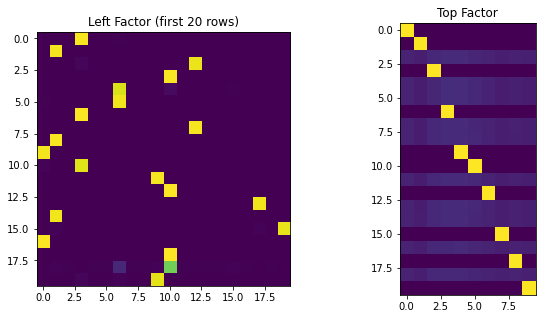

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

num_rows_to_display = num_subclasses
ax1.set_title(f"Left Factor (first {num_rows_to_display} rows)")
ax1.imshow(results["left"][:num_rows_to_display])
ax2.set_title("Top Factor")
ax2.imshow(results["top"])

### Non-working method: Solve for both factors simulataneously  

Haven't been able to make this approach converge at any reasonable scale.

In [51]:
# def coeffs_to_matrices(x: np.ndarray, num_elements: int, 
#                        num_subclasses: int) -> Tuple[np.ndarray, np.ndarray]:
#     """
#     :param x: The coefficients of the two factors, concatenated together
#      into a single 1D array per the ``scipy.optimize.minimize`` API.
#      Left factor first, top factor second.
#     :param num_elements
#     :param num_subclasses: Number of hidden subclasses to solve for, also
#      known as the common dimension of the two factors.

#     :returns: Tuple of the left and top factors, extracted from ``x``.
#     """
#     left_factor_size = (num_elements, num_subclasses)
#     top_factor_size = (num_subclasses, num_classes)
#     left_factor_num_elems = left_factor_size[0] * left_factor_size[1]
#     top_factor_num_elems = top_factor_size[0] * top_factor_size[1]

#     if len(x) != left_factor_num_elems + top_factor_num_elems:
#         # Sanity check
#         raise ValueError(
#             f"Unexpected number of elements in x; "
#             f"got {len(x)}, expected "
#             f"{left_factor_num_elems + top_factor_num_elems}")

#     left_factor = x[0:left_factor_num_elems].reshape(left_factor_size)
#     top_factor = x[left_factor_num_elems:].reshape(top_factor_size)

#     return (left_factor, top_factor)


# def matrices_to_coeffs(left_factor: np.ndarray, top_factor: np.ndarray) -> np.ndarray:
#     """
#     Inverse of :func:`coeffs_to_matrices`.

#     :param left_factor: First operand of the matrix multiply in the
#      problem formulation.
#     :param top_factor: Second operand of the matrix multiply.

#     :returns: Concatenation of the coefficients of ``left_factor`` and 
#      ``top_factor`` into a single 1D array suitable for the API of
#      :func:`scipy.optimize.minimize`
#     """
#     return np.concatenate((left_factor.flatten(), top_factor.flatten()))


# def loss_function(x: np.ndarray, 
#                   model_probs: np.ndarray,
#                   num_subclasses: int,
#                   left_reg_coeff: float,
#                   top_reg_coeff: float) -> float:
#     """
#     :param x: The coefficients of the two factors, concatenated together
#      into a single 1D array per the ``scipy.optimize.minimize`` API.
#      Left factor first, top factor second.
#     :model_probs: Returned probabilities from the model.
#     :param num_subclasses: Number of hidden subclasses to solve for, also
#      known as the common dimension of the two factors.
#     :param left_reg_coeff: Regularization coefficient for the value of the
#      left factor, which is L1 regularized.
#     :param top_reg_coeff: Regularization coefficient for the value of the
#      top factor, which is L2 regularized.

#     :returns: Total loss
#     """
#     num_elements = model_probs.shape[0]
#     (left_factor, top_factor) = coeffs_to_matrices(x, num_elements,
#                                                    num_subclasses)

#     product = np.matmul(left_factor, top_factor)

#     # Basic loss is L2 norm of the difference between the product of 
#     # the factors and the model's output probabilities
#     base_loss = np.linalg.norm(product - model_probs)

#     # We L1-regularize the left factor to encourage sparsity.
#     left_reg_penalty = left_reg_coeff * np.sum(left_factor)

#     # We L2-regularlize the top factor to discourage the optimizer from
#     # picking the identity matrix
#     top_reg_penalty = top_reg_coeff * np.linalg.norm(top_factor)

#     return base_loss + left_reg_penalty + top_reg_penalty

In [52]:
# num_subclasses = 20
# left_reg_coeff = 0.
# top_reg_coeff = 0.

# # Optionally sample to make things faster
# num_examples = 100
# if num_examples > len(c_test.index):
#     raise ValueError(f"Too many examples requested"
#                      f"({num_examples} > {len(c_test.index)}")

# # Use kmeans to generate some starting values.
# model_probs = c_test.sample(num_examples)["probs"].to_numpy()
# kmeans = sklearn.cluster.KMeans(n_clusters=num_subclasses)
# cluster_ids = kmeans.fit_predict(model_probs)
# clusters = kmeans.cluster_centers_

# # Dummy-code the cluster IDs from KMeans
# left_factor = np.zeros((num_examples, num_subclasses), dtype=np.float32)
# left_factor[range(num_examples), cluster_ids] = 1.
# top_factor = clusters

# starting_values = matrices_to_coeffs(left_factor, top_factor)

# initial_loss = loss_function(starting_values, model_probs, num_subclasses, 
#                              left_reg_coeff, top_reg_coeff)

# print(f"Initial loss: {initial_loss}")

In [53]:
# # Scipy constraint format is lb <= A.dot(x) <= ub
# # We need to generate a mask `A` with one row for each constraint.

# # Constrain each row of the top factor to sum to 1 +/- epsilon
# epsilon = 0.0

# top_masks = []
# for subclass_num in range(num_subclasses):
#     mask = np.zeros((num_subclasses, num_classes))
#     mask[subclass_num, :] = 1.
#     top_masks.append(mask)

# #np.stack(masks).reshape((num_subclasses, -1))

# # Constrain each row of the left factor to sum to 1 +/- epsilon
# left_masks = []
# for example_num in range(num_examples):
#     mask = np.zeros((num_examples, num_subclasses))
#     mask[example_num, :] = 1.
#     left_masks.append(mask)


# # Now we need to pad each mask with the appropriate number of zeros
# top_padding = np.zeros((num_examples, num_subclasses))
# left_padding = np.zeros((num_subclasses, num_classes))

# flat_top_masks = [
#     matrices_to_coeffs(top_padding, mask)
#     for mask in top_masks]
# flat_left_masks = [
#     matrices_to_coeffs(mask, left_padding)
#     for mask in left_masks]

# A = np.stack(flat_top_masks + flat_left_masks)
# lb = np.full(A.shape[0], 1. - epsilon)
# ub = np.full(A.shape[0], 1. + epsilon)
# constraints = scipy.optimize.LinearConstraint(
#     # A: {array_like, sparse matrix}, shape (m, n): Matrix defining the constraint.
#     A,
#     # lb: array_like: Lower bounds
#     lb,
#     # ub: array_like: Upper bounds
#     ub,
#     keep_feasible=False)

In [54]:
# Sanity check: Everything should be exactly 1 to start out.
# A.dot(starting_values)

In [55]:
# %%time

# fixed_args = (model_probs, num_subclasses, left_reg_coeff, top_reg_coeff)
# bounds = [(0., 1.) for _ in starting_values]


# result = scipy.optimize.minimize(loss_function, starting_values,
#                                  args=fixed_args, bounds=bounds,
#                                  method="trust-constr",
#                                  constraints=constraints
#                                  #options={"maxiter": 100000}
#                                 )

#result

In [56]:
# # Unpack the model outputs
# solution = result.x
# left_factor, top_factor = coeffs_to_matrices(solution, num_examples, num_subclasses)

In [57]:
# # Compute final loss
# loss_function(solution, model_probs, num_subclasses, left_reg_coeff, top_reg_coeff)

In [58]:
# left_factor[4]

In [59]:
# plt.imshow(np.log(top_factor))

In [60]:
# plt.imshow(np.log(left_factor[:15]))